# Preprocesamiento y modelado de datos de viviendas

## Importación de librerías y carga de datos

In [15]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
import optuna
import pickle
import bz2

In [16]:
df_inicial = pd.read_csv("../data/final/viviendas_2011_2024.csv")
df_inicial.head()

,Ano,Distrito,Esperanza_vida,Renta_neta_persona,Renta_neta_hogar,Renta_bruta_persona,Renta_bruta_hogar,Edad_media,Mayores_65anos%,Menores_18anos%,...,Terraza,Planta,Exterior,Ascensor,Ano_construccion,Ano_reforma,Tipo_vivienda,Banos,Precio_predicho,Precio_ajustado
0,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,False,NaN,NaN,apartamento,1,672.875811,657.471490
1,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,5.0,True,True,NaN,NaN,apartamento,1,923.555035,894.792822
2,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,3.0,True,True,1910.0,NaN,apartamento,2,1424.913483,1434.552312
3,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,4.0,True,True,NaN,NaN,apartamento,1,2240.808388,2335.359589
4,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,3.0,True,True,1940.0,NaN,apartamento,1,1583.237203,1571.481771


## Preprocesamiento

Revisar notebook [EDA_viviendas_2011_2024](./EDA_viviendas_2011_2024.ipynb) para visualizar el análisis que da lugar a las decisiones tomadas en el preprocesamiento.

### 1. Eliminar e imputar columnas

Eliminación de variables fuertemente correlacionadas, de variables con más del 90% de nulos e imputación de nulos de la columna "Planta".

In [17]:
df = df_inicial.copy()

df = df[df['Ano'] >= 2015]

# Elminación de Ano_construccion y Ano_reforma por exceso de nulos
df = df.drop(columns=['Ano_construccion', 'Ano_reforma'])

# Crear columna de indicador de nulos para Planta
df['Planta_is_missing'] = df['Planta'].isna().astype(int)

# Imputar valores nulos con la mediana para Planta (por distrito)
df['Planta'] = df.groupby('Distrito')['Planta'].transform(lambda x: x.fillna(x.median()))

# Variables muy correlacionadas y no usadas
var_corr = ['Tamano_vivienda_personas', 'Densidad_poblacion', 'Edad_media', 'Renta_neta_persona',
            'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar', 'Precio_predicho']

df = df.drop(columns=var_corr)

print('Columnas restantes:', df.columns.to_list())

Columnas restantes: ['Ano', 'Distrito', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos', 'Superficie_distrito_ha', 'Zonas_verdes%', 'Habitaciones', 'Operacion', 'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Tipo_vivienda', 'Banos', 'Precio_ajustado', 'Planta_is_missing']


Imputamos variables socioeconómicas faltantes en 2023 y 2024 para poder hacer una predicción de prueba. Primero, calculamos las **tendencias** para ver cómo varían los valores.

In [18]:
from sklearn.linear_model import LinearRegression

def calcular_tendencia(grupo, cols):
    X = grupo['Ano'].values.reshape(-1, 1)
    tendencias = {}
    for c in cols:
        y = grupo[c].values
        if np.allclose(y, y[0], atol=1e-8):  # valores constantes
            tendencias[c] = 0.0
        elif len(np.unique(X)) > 1:
            modelo = LinearRegression().fit(X, y)
            tendencias[c] = modelo.coef_[0]
        else:
            tendencias[c] = np.nan
    return pd.Series(tendencias)

variables = ['Esperanza_vida', 'Mayores_65anos%',
       'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos',
       'Superficie_distrito_ha', 'Zonas_verdes%']
cols = ['Ano'] + variables
tendencias = df.dropna().groupby('Distrito')[cols].apply(calcular_tendencia, cols=variables).reset_index()

In [19]:
tendencias

,Distrito,Esperanza_vida,Mayores_65anos%,Menores_18anos%,Paro_registrado%,Apartamentos_turisticos,Superficie_distrito_ha,Zonas_verdes%
0,ARGANZUELA,-0.015476,0.003429,-0.002690,-0.002182,0.142857,0.0,0.0
1,BARAJAS,0.119048,0.002905,-0.002274,-0.001530,0.083333,0.0,0.0
2,CARABANCHEL,0.027381,-0.002262,-0.001845,-0.002469,0.547619,0.0,0.0
3,CENTRO,0.067857,-0.000940,-0.002607,-0.002150,3.404762,0.0,0.0
4,CHAMARTIN,0.032143,0.001143,-0.000310,-0.001232,0.190476,0.0,0.0
5,CHAMBERI,0.075000,0.000405,-0.001024,-0.001527,0.321429,0.0,0.0
6,CIUDADLINEAL,0.009524,-0.000619,-0.002143,-0.002183,0.285714,0.0,0.0
7,FUENCARRALELPARDO,0.041667,0.001774,0.000071,-0.001628,0.000000,0.0,0.0
8,HORTALEZA,0.091667,0.000214,0.000071,-0.001832,0.083333,0.0,0.0
9,LATINA,-0.019048,-0.002083,-0.001250,-0.002176,0.000000,0.0,0.0


In [20]:
vars_faltantes = ['Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%']

# Añadimos columna de indicador de nulos para cada variable
for var in vars_faltantes:
    df[f"{var}_is_missing"] = df[var].isna().astype(int)

df[vars_faltantes] = (
    df.groupby("Distrito")[vars_faltantes]
      .apply(lambda x: x.ffill().bfill())
      .reset_index(level=0, drop=True)
)

In [21]:
resumen = pd.DataFrame({
    "Tipo": df.dtypes,
    "Nulos": df.isna().sum(),
    "Nulos_%": (df.isna().mean()*100).round(2)
})
print(resumen)

                                Tipo  Nulos  Nulos_%
Ano                            int64      0      0.0
Distrito                      object      0      0.0
Esperanza_vida               float64      0      0.0
Mayores_65anos%              float64      0      0.0
Menores_18anos%              float64      0      0.0
Paro_registrado%             float64      0      0.0
Apartamentos_turisticos      float64      0      0.0
Superficie_distrito_ha       float64      0      0.0
Zonas_verdes%                float64      0      0.0
Habitaciones                   int64      0      0.0
Operacion                     object      0      0.0
Tamano                       float64      0      0.0
Garaje                          bool      0      0.0
Trastero                        bool      0      0.0
Piscina                         bool      0      0.0
Terraza                         bool      0      0.0
Planta                       float64      0      0.0
Exterior                        bool      0   

### 2. Transformar variables categóricas

Se deben pasar las variables categóricas a numéricas para poder procesarlas correctamente con los modelos. Las tres variables categóricas son `Distrito`, `Operacion` y `Tipo_vivienda`. Como no son variables que tengan jerarquía, usaremos dummies para transformarlas.

In [22]:
df = pd.get_dummies(df, drop_first=True)

print(df.columns)

Index(['Ano', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%',
       'Paro_registrado%', 'Apartamentos_turisticos', 'Superficie_distrito_ha',
       'Zonas_verdes%', 'Habitaciones', 'Tamano', 'Garaje', 'Trastero',
       'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Banos',
       'Precio_ajustado', 'Planta_is_missing', 'Mayores_65anos%_is_missing',
       'Menores_18anos%_is_missing', 'Paro_registrado%_is_missing',
       'Distrito_BARAJAS', 'Distrito_CARABANCHEL', 'Distrito_CENTRO',
       'Distrito_CHAMARTIN', 'Distrito_CHAMBERI', 'Distrito_CIUDADLINEAL',
       'Distrito_FUENCARRALELPARDO', 'Distrito_HORTALEZA', 'Distrito_LATINA',
       'Distrito_MONCLOAARAVACA', 'Distrito_MORATALAZ',
       'Distrito_PUENTEDEVALLECAS', 'Distrito_RETIRO', 'Distrito_SALAMANCA',
       'Distrito_SANBLASCANILLEJAS', 'Distrito_TETUAN', 'Distrito_USERA',
       'Distrito_VICALVARO', 'Distrito_VILLADEVALLECAS', 'Distrito_VILLAVERDE',
       'Operacion_venta', 'Tipo_vivienda_chalet', '

### 3. Dividir en entrenamiento, validación y test

Escogeremos años de 2015 a 2022 (ambos inclusive) para entrenamiento; y años 2023 y 2024 para test.

In [23]:
test_mask = (df["Ano"] >= 2023)
df_test = df[test_mask].copy()

### 4. Preparar un pipeline de datos

Se utilizará un pipeline para facilitar el manejo de datos y evitar fugas. Para ello, elegimos un escalado robusto para procesar mejor los outliers; y un modelo para entrenar.

In [24]:
def definir_pipeline(modelo) -> Pipeline:
    """
    Función para aplicar escalado y decidir el modelo que se usará.
    
    Parameters
    ----------
    modelo : KNN, XGBoost, MLP...
        Se pueden incluir los parámetros manualmente dentro del modelo.
    
    Returns
    ----------
        pipeline
    """

    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('modelo', modelo)
    ])

    return pipeline

**Faltaría a partir de aquí elegir modelos (recomendado por lo menos: baseline con un modelo linear o de distancias; un modelo de árboles; y un MLP). Se puede hacer optimización inteligente con Optuna. Validación para hacer pruebas, test cuando ya se haya optimizado lo posible.**

**Definición de variables, división temporal de datos y función de evaluación del modelo**

Variables predictoras (X) y la variable objetivo (y), separando los datos en entrenamiento (2015–2021) y validación (2022) para evitar fuga temporal. 
Además, se implementa una función de evaluación que entrena el modelo y calcula métricas de rendimiento (MAE, RMSE, MAPE y R²) en ambos conjuntos.

In [27]:
# --- 1. Filtrar rango completo sin nulos ---
df = df.sort_values(by="Ano").reset_index(drop=True)
df = df.dropna(subset=["Precio_ajustado"])

# --- 2. Crear features temporales ---
df = df.sort_values(by="Ano").reset_index(drop=True)

mask_train = (df["Ano"] <= 2022)
df.loc[mask_train, "lag_1"] = df.loc[mask_train, "Precio_ajustado"].shift(1)
df.loc[mask_train, "lag_2"] = df.loc[mask_train, "Precio_ajustado"].shift(2)
df.loc[mask_train, "rolling_mean_3"] = (
    df.loc[mask_train, "Precio_ajustado"].shift(1).rolling(window=3).mean()
)
df.loc[mask_train, :] = df.loc[mask_train].dropna(subset=["lag_1", "lag_2", "rolling_mean_3"]).reset_index(drop=True)  # quitar filas con NA generadas solo hasta 2022

# --- 3. Definir X / y ---
TARGET_COL = "Precio_ajustado"
DROP_COLS = ["Ano", TARGET_COL] # Eliminamos año porque ya tenemos lags temporales y media móvil

FEATURES = [c for c in df.columns if c not in DROP_COLS]

# Separación temporal
mask_train = (df["Ano"] <= 2022)
mask_test  = (df["Ano"] >= 2023)

X_train = df.loc[mask_train, FEATURES]
y_train = df.loc[mask_train, TARGET_COL]
X_test  = df.loc[mask_test, FEATURES]
y_test  = df.loc[mask_test, TARGET_COL]

X = df[FEATURES]
y = df[TARGET_COL]

In [10]:
# --- 4. Función de evaluación ---
def evaluar(model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }

In [11]:
# --- 5. Definir modelos para probar ---
modelos = {
    "ridge": definir_pipeline(Ridge(alpha=1.0, random_state=42)),
    "knn":   definir_pipeline(KNeighborsRegressor(n_neighbors=7, weights="distance", n_jobs=-1)),
    "rf":    definir_pipeline(RandomForestRegressor(
                n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
    "hgb":   definir_pipeline(HistGradientBoostingRegressor(
                max_depth=None, learning_rate=0.06, max_iter=500, random_state=42)),
    "mlp":   definir_pipeline(MLPRegressor(
                hidden_layer_sizes=(64, 32),
                max_iter=300,
                activation="relu",
                learning_rate_init=1e-3,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=42)),
}

In [12]:
# --- 6. Validación temporal tipo rolling window ---
splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
resultados = {}
entrenados = {}

**Entrenamientos de prueba (descomentar para ejecutar):**

In [13]:
# # Entrenamientos de prueba
# for nombre, pipe in modelos.items():
#     print(f"Entrenando modelo {nombre}...")
#     resultados_modelo = []
#     n_validacion = 0
#     for train_index, val_index in tscv.split(X):
#         n_validacion += 1
#         print(f"   Split {n_validacion}/{splits}")

#         pipe_cv = clone(pipe) # Clonar pipeline cada split para evitar sesgos

#         X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         metrics = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
#         resultados_modelo.append(metrics)

#     resultados[nombre] = resultados_modelo

#     # Entrenamiento final con todo el conjunto
#     print("   Fit final")
#     pipe_final = clone(pipe).fit(X_train, y_train)
#     entrenados[nombre] = pipe_final

# # --- 7. Mostrar resultados ---
# print("\nRESULTADOS DE EVALUACIÓN 2015-2022:")
# ranking = sorted(
#     resultados.items(),
#     key=lambda kv: min([m["MAE_val"] for m in kv[1]])  # Ordenar por mejor MAE_val
# )

# for nombre, metricas in ranking:
#     mae_vals = [m["MAE_val"] for m in metricas]
#     rmse_vals = [m["RMSE_val"] for m in metricas]
#     r2_vals = [m["R2_val"] for m in metricas]
#     mape_vals = [m["MAPE_val_%"] for m in metricas]

#     mae_tr_vals = [m["MAE_train"] for m in metricas]
#     rmse_tr_vals = [m["RMSE_train"] for m in metricas]
#     r2_tr_vals = [m["R2_train"] for m in metricas]

#     print(f"{nombre}:")
#     print(f"  Mejor MAE_val   = {min(mae_vals):.3f}")
#     print(f"  Mejor RMSE_val  = {min(rmse_vals):.3f}")
#     print(f"  Mejor R2_val    = {max(r2_vals):.3f}")
#     print(f"  Mejor MAPE_val  = {min(mape_vals):.2f}%")
#     print(f"  Mejor MAE_train = {min(mae_tr_vals):.3f}")
#     print(f"  Mejor RMSE_train= {min(rmse_tr_vals):.3f}")
#     print(f"  Mejor R2_train  = {max(r2_tr_vals):.3f}")

# mejor_nombre = ranking[0][0]
# mejor_modelo = entrenados[mejor_nombre]
# print("\nMejor modelo:", mejor_nombre)

**Optimización de hiperparámetros del modelo Random Forest mediante Optuna (descomentar para ejecutar)**

Se utiliza la librería Optuna para ajustar automáticamente los hiperparámetros del modelo Random Forest. A través de múltiples iteraciones, se buscan las combinaciones que minimicen el error absoluto medio (MAE) en validación, obteniendo así el conjunto de parámetros con el mejor rendimiento predictivo.

In [14]:
# # ===== Paso 4: Optimización con Optuna (Random Forest) =====

# # Definir los splits fuera de la función para no recrearlos en cada trial
# tscv = TimeSeriesSplit(n_splits=splits)

# def objective_rf(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 200, 300, step=100),
#         "max_depth": trial.suggest_int("max_depth", 5, 15, step=5),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=2),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.8]),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#         "n_jobs": -1,
#         "random_state": 42
#     }

#     pipe = definir_pipeline(RandomForestRegressor(**params))

#     maes = []
#     for train_idx, val_idx in tscv.split(X):
#         pipe_cv = clone(pipe) # Clonar pipeline en cada split para evitar sesgos

#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
#         mets = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
#         maes.append(mets["MAE_val"])

#     return np.mean(maes)  # Usar promedio del MAE en los splits como métrica de validación

# # Crear estudio de Optuna y ejecutarlo
# study = optuna.create_study(direction="minimize", study_name="Optimizacion_rf")
# study.optimize(objective_rf, n_trials=20, show_progress_bar=True)

# print("Best MAE_val:", study.best_value)
# print("Best params:", study.best_params)

**Entrenamiento del modelo Random Forest final con los mejores hiperparámetros (descomentar para ejecutar)**

Se entrena el modelo Random Forest utilizando los hiperparámetros óptimos encontrados con Optuna. El modelo final se integra en un pipeline con escalado robusto y se ajusta sobre los datos de entrenamiento completos, obteniendo así la versión definitiva lista para evaluación y predicciones futuras.

In [15]:
# # ===== Entrenar el mejor modelo RF final =====
# rf_final = definir_pipeline(RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=42))

# # Entrenar con todos los datos (ya que es una serie temporal)
# rf_final.fit(X_train, y_train)

Guardar modelo

In [16]:
# import bz2

# with bz2.open('../models/rf_final.pkl.bz2', 'wb') as f:
#     pickle.dump(rf_final, f)

Cargar modelo

In [17]:
with bz2.open('../models/rf_final.pkl.bz2', 'rb') as f:
    rf_final = pickle.load(f)

**Análisis de la importancia de variables en el modelo Random Forest**

Se extraen y visualizan las variables con mayor peso en el modelo final de Random Forest. Este análisis permite identificar los factores que más influyen en la predicción del precio ajustado, mostrando las 15 variables más relevantes mediante una tabla y un gráfico de barras.

,Variable,Importancia
49,lag_1,0.360351
51,rolling_mean_3,0.282544
8,Tamano,0.224143
41,Operacion_venta,0.034781
50,lag_2,0.033348
7,Habitaciones,0.016680
3,Paro_registrado%,0.008817
4,Apartamentos_turisticos,0.006961
13,Planta,0.005357
2,Menores_18anos%,0.004393


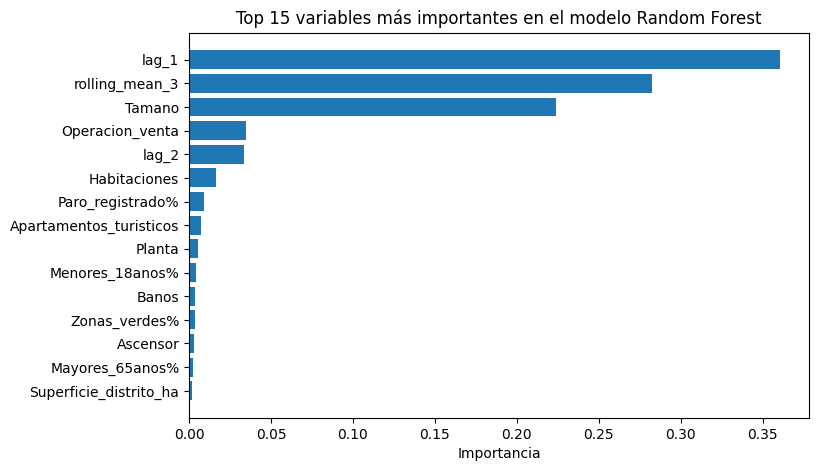

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer importancias
importancias = rf_final.named_steps['modelo'].feature_importances_
features = X_train.columns

# Crear DataFrame ordenado
imp_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False).head(15)

# Mostrar tabla y gráfico
display(imp_df)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Variable'], imp_df['Importancia'])
plt.gca().invert_yaxis()
plt.title('Top 15 variables más importantes en el modelo Random Forest')
plt.xlabel('Importancia')
plt.show()

Evaluación en 2023 y 2024

In [30]:
# Primero aseguramos que estén bien indexados
tendencias = tendencias.set_index('Distrito')

# Iteramos sobre cada fila del df
for col in tendencias.columns:
    for year in [2023, 2024]:
        mask = (df['Ano'] == year) & (df[col].isna())
        df.loc[mask, col] = (
            df.loc[(df['Ano'] == 2022) & (df['Distrito'] == df.loc[mask, 'Distrito'].values[0]), col].values[0]
            + tendencias.loc[df.loc[mask, 'Distrito'], col].values * (year - 2022)
        )

KeyError: "None of ['Distrito'] are in the columns"

In [19]:
def evaluar_sin_fit(model, X_tr, y_tr, X_va, y_va):
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }

In [20]:
print("\n--- Evaluación en 2023 ---")
eval_2023 = evaluar_sin_fit(rf_final, X_train, y_train,
                    X_test.loc[df["Ano"] == 2023],
                    y_test.loc[df["Ano"] == 2023])
print(eval_2023)

print("\n--- Evaluación en 2024 ---")
eval_2024 = evaluar_sin_fit(rf_final, X_train, y_train,
                    X_test.loc[df["Ano"] == 2024],
                    y_test.loc[df["Ano"] == 2024])
print(eval_2024)


--- Evaluación en 2023 ---
{'MAE_train': 25861.80921512049, 'RMSE_train': np.float64(51916.02491567927), 'R2_train': 0.9874790446846711, 'MAE_val': 100356.51673327776, 'RMSE_val': np.float64(353165.6459632238), 'MAPE_val_%': np.float64(26.426617034650402), 'R2_val': 0.5971338965728346}

--- Evaluación en 2024 ---
{'MAE_train': 25861.80921512049, 'RMSE_train': np.float64(51916.02491567926), 'R2_train': 0.9874790446846711, 'MAE_val': 127766.59516810544, 'RMSE_val': np.float64(426212.4710442884), 'MAPE_val_%': np.float64(26.580277186980698), 'R2_val': 0.5406276068429319}


**Comparativa de desempeño entre el modelo base y el modelo optimizado**

Se comparan los resultados del modelo Random Forest inicial frente al modelo optimizado tras la búsqueda de hiperparámetros. El modelo ajustado muestra una mejora en el MAE y MAPE de validación, manteniendo un R² alto, lo que confirma una mayor precisión y mejor capacidad de generalización.

In [ ]:
rf_base = entrenados["rf"]  # el modelo base antes del tuning

base_mets = resultados["rf"]
tuned_mets = evaluar(rf_final, X_train, y_train, X_val, y_val)

print("\n--- Comparativa Random Forest ---")
print("Base :", base_mets)
print("Tuned:", tuned_mets)